<h1><center>Pixel CNN for Grayscale Images</center></h1>

[The original ***Pixel Recurrent Neural Networks*** paper](https://arxiv.org/abs/1601.06759)

[Impl of Masked Convolution](https://github.com/jzbontar/pixelcnn-pytorch/blob/master/main.py)

In [20]:
import torch
from torch import nn
from torch import optim
from torch.utils import data
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import sys
import os
import time

from torchvision import datasets, transforms
import configparser
import os

from matplotlib import pyplot as plt
import cv2

# Model

In [4]:
class MaskedCNN(nn.Conv2d):
    """
    Implementation of Masked CNN Class as explained in A Oord et. al. 
    Taken from https://github.com/jzbontar/pixelcnn-pytorch
    """

    def __init__(self, mask_type, *args, **kwargs):
        self.mask_type = mask_type
        assert mask_type in ['A', 'B'], "Unknown Mask Type"
        super(MaskedCNN, self).__init__(*args, **kwargs)
        self.register_buffer('mask', self.weight.data.clone())

        _, depth, height, width = self.weight.size()
        self.mask.fill_(1)
        if mask_type =='A':
            self.mask[:,:,height//2,width//2:] = 0
            self.mask[:,:,height//2+1:,:] = 0
        else:
            self.mask[:,:,height//2,width//2+1:] = 0
            self.mask[:,:,height//2+1:,:] = 0


    def forward(self, x):
        self.weight.data*=self.mask
        return super(MaskedCNN, self).forward(x)
    
class PixelCNN(nn.Module):
    """
    Network of PixelCNN as described in A Oord et. al. 
    """
    def __init__(self, no_layers=8, kernel = 7, channels=64, device=None):
        super(PixelCNN, self).__init__()
        self.no_layers = no_layers
        self.kernel = kernel
        self.channels = channels
        self.layers = {}
        self.device = device

        self.Conv2d_1 = MaskedCNN('A',1,channels, kernel, 1, kernel//2, bias=False)
        self.BatchNorm2d_1 = nn.BatchNorm2d(channels)
        self.ReLU_1= nn.ReLU(True)

        self.Conv2d_2 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
        self.BatchNorm2d_2 = nn.BatchNorm2d(channels)
        self.ReLU_2= nn.ReLU(True)

        self.Conv2d_3 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
        self.BatchNorm2d_3 = nn.BatchNorm2d(channels)
        self.ReLU_3= nn.ReLU(True)

        self.Conv2d_4 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
        self.BatchNorm2d_4 = nn.BatchNorm2d(channels)
        self.ReLU_4= nn.ReLU(True)

        self.Conv2d_5 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
        self.BatchNorm2d_5 = nn.BatchNorm2d(channels)
        self.ReLU_5= nn.ReLU(True)

        self.Conv2d_6 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
        self.BatchNorm2d_6 = nn.BatchNorm2d(channels)
        self.ReLU_6= nn.ReLU(True)

        self.Conv2d_7 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
        self.BatchNorm2d_7 = nn.BatchNorm2d(channels)
        self.ReLU_7= nn.ReLU(True)

        self.Conv2d_8 = MaskedCNN('B',channels,channels, kernel, 1, kernel//2, bias=False)
        self.BatchNorm2d_8 = nn.BatchNorm2d(channels)
        self.ReLU_8= nn.ReLU(True)

        self.out = nn.Conv2d(channels, 256, 1)

    def forward(self, x):
        x = self.Conv2d_1(x)
        x = self.BatchNorm2d_1(x)
        x = self.ReLU_1(x)

        x = self.Conv2d_2(x)
        x = self.BatchNorm2d_2(x)
        x = self.ReLU_2(x)

        x = self.Conv2d_3(x)
        x = self.BatchNorm2d_3(x)
        x = self.ReLU_3(x)

        x = self.Conv2d_4(x)
        x = self.BatchNorm2d_4(x)
        x = self.ReLU_4(x)

        x = self.Conv2d_5(x)
        x = self.BatchNorm2d_5(x)
        x = self.ReLU_5(x)

        x = self.Conv2d_6(x)
        x = self.BatchNorm2d_6(x)
        x = self.ReLU_6(x)

        x = self.Conv2d_7(x)
        x = self.BatchNorm2d_7(x)
        x = self.ReLU_7(x)

        x = self.Conv2d_8(x)
        x = self.BatchNorm2d_8(x)
        x = self.ReLU_8(x)

        return self.out(x)

# Useful

In [5]:
def get_MNIST(path):
    """
    Loads the train and test MNIST data and returns both after 
    trainsforming the images to tensors. Downloads the data if 
    not on local path
    """
    assert os.path.exists(path), 'The dataloading path does not exist!'
    train_data = datasets.MNIST(root=path,
                                train=True,
                                download=True,
                                transform=transforms.ToTensor())
    test_data = datasets.MNIST(root=path,
                               train=False,
                               download=True,
                               transform=transforms.ToTensor())
    return train_data, test_data


def parse_config(filename):
    config = configparser.ConfigParser()
    config.read(filename)
    output = {}
    for section in config.sections():
        output[section] = {}
        for key in config[section]:
            val_str = str(config[section][key])
            if(len(val_str)>0):
                val = parse_value_from_string(val_str) 
            else:
                val = None
            print(section, key,val_str, val)
            output[section][key] = val
    return output



def parse_value_from_string(val_str):
    if(is_int(val_str)):
        val = int(val_str)
    elif(is_float(val_str)):
        val = float(val_str)
    elif(is_list(val_str)):
        val = parse_list(val_str)
    elif(is_bool(val_str)):
        val = parse_bool(val_str)
    else:
        val = val_str
    return val

def is_int(val_str):
    start_digit = 0
    if(val_str[0] =='-'):
        start_digit = 1
    flag = True
    for i in range(start_digit, len(val_str)):
        if(str(val_str[i]) < '0' or str(val_str[i]) > '9'):
            flag = False
            break
    return flag

def is_float(val_str):
    flag = False
    if('.' in val_str and len(val_str.split('.'))==2):
        if(is_int(val_str.split('.')[0]) and is_int(val_str.split('.')[1])):
            flag = True
        else:
            flag = False
    elif('e' in val_str and len(val_str.split('e'))==2):
        if(is_int(val_str.split('e')[0]) and is_int(val_str.split('e')[1])):
            flag = True
        else:
            flag = False       
    else:
        flag = False
    return flag 

def is_bool(var_str):
    if( var_str=='True' or var_str == 'true' or var_str =='False' or var_str=='false'):
        return True
    else:
        return False
    
def parse_bool(var_str):
    if(var_str=='True' or var_str == 'true' ):
        return True
    else:
        return False
     
def is_list(val_str):
    if(val_str[0] == '[' and val_str[-1] == ']'):
        return True
    else:
        return False
    
def parse_list(val_str):
    sub_str = val_str[1:-1]
    splits = sub_str.split(',')
    output = []
    for item in splits:
        item = item.strip()
        if(is_int(item)):
            output.append(int(item))
        elif(is_float(item)):
            output.append(float(item))
        elif(is_bool(item)):
            output.append(parse_bool(item))
        else:
            output.append(item)
    return output

# Training

In [7]:
def main():
    path = 'data' #Path where the data after loading is to be saved
    data_name = 'MNIST' #What data type is to be loaded ex - MNIST, CIFAR
    batch_size = 16

    layers = 8 #Number of layers in the network
    kernel = 7 #Kernel size
    channels = 64 #Depth of the intermediate layers
    epochs = 25 #No of epochs
    save_path = 'models' #path where the models are to be saved

    #Loading Data
    train, test = get_MNIST(path)
    train = data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers =1, pin_memory = True)
    test = data.DataLoader(train, batch_size=batch_size, shuffle=False, num_workers =1, pin_memory = True)

    #Defining the model and training it on loss function
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = PixelCNN().to(device)
    if torch.cuda.device_count() > 1: # If more than one GPU available, accelerate the training using multiple GPUs
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        net = nn.DataParallel(net)

    optimizer = optim.Adam(net.parameters())
    criterion = nn.CrossEntropyLoss()

    loss_overall = []
    time_start = time.time()
    print('Training Started')

    for i in range(epochs):
        net.train(True)
        step = 0
        loss_= 0
        for images, labels in train:
            target = Variable(images[:,0,:,:]*255).long()
            images = images.to(device)
            target = target.to(device)
            optimizer.zero_grad()

            output = net(images)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            loss_+=loss
            step+=1

            if(step%100 == 0):
                print('Epoch:'+str(i)+'\t'+ str(step) +'\t Iterations Complete \t'+'loss: ', loss.item()/1000.0)
                loss_overall.append(loss_/1000.0)
                loss_=0
        print('Epoch: '+str(i)+' Over!')

        #Saving the model
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        print("Saving Checkpoint!")
        if(i==epochs-1):
            torch.save(net.state_dict(), save_path+'/Model_Checkpoint_'+'Last'+'.pt')
        else:
            torch.save(net.state_dict(), save_path+'/Model_Checkpoint_'+str(i)+'.pt')
        print('Checkpoint Saved')


    print('Training Finished! Time Taken: ', time.time()-time_start)
    
main()

Training Started
Epoch:0	100	 Iterations Complete 	loss:  0.001333816170692444
Epoch:0	200	 Iterations Complete 	loss:  0.0011296346187591553
Epoch:0	300	 Iterations Complete 	loss:  0.0010412464141845703
Epoch:0	400	 Iterations Complete 	loss:  0.0009617800712585449
Epoch:0	500	 Iterations Complete 	loss:  0.0009509155750274658
Epoch:0	600	 Iterations Complete 	loss:  0.0008314587473869324
Epoch:0	700	 Iterations Complete 	loss:  0.0008405165672302246
Epoch:0	800	 Iterations Complete 	loss:  0.0008414555788040161
Epoch:0	900	 Iterations Complete 	loss:  0.0008013854026794433
Epoch:0	1000	 Iterations Complete 	loss:  0.0009042335748672486
Epoch:0	1100	 Iterations Complete 	loss:  0.0008522272706031799
Epoch:0	1200	 Iterations Complete 	loss:  0.0007881550192832947
Epoch:0	1300	 Iterations Complete 	loss:  0.0008500093817710876
Epoch:0	1400	 Iterations Complete 	loss:  0.0008202027082443238
Epoch:0	1500	 Iterations Complete 	loss:  0.0008646810054779053
Epoch:0	1600	 Iterations Complete

Epoch:3	1700	 Iterations Complete 	loss:  0.0006905372142791748
Epoch:3	1800	 Iterations Complete 	loss:  0.0006612591743469238
Epoch:3	1900	 Iterations Complete 	loss:  0.0007636811137199401
Epoch:3	2000	 Iterations Complete 	loss:  0.00073492431640625
Epoch:3	2100	 Iterations Complete 	loss:  0.0007786822319030762
Epoch:3	2200	 Iterations Complete 	loss:  0.0007318698167800903
Epoch:3	2300	 Iterations Complete 	loss:  0.000704963743686676
Epoch:3	2400	 Iterations Complete 	loss:  0.0006772449016571045
Epoch:3	2500	 Iterations Complete 	loss:  0.0007401662468910217
Epoch:3	2600	 Iterations Complete 	loss:  0.0006869679093360901
Epoch:3	2700	 Iterations Complete 	loss:  0.0007332454323768615
Epoch:3	2800	 Iterations Complete 	loss:  0.0007047709822654724
Epoch:3	2900	 Iterations Complete 	loss:  0.0007784171104431153
Epoch:3	3000	 Iterations Complete 	loss:  0.0006192818880081176
Epoch:3	3100	 Iterations Complete 	loss:  0.0006099019050598145
Epoch:3	3200	 Iterations Complete 	loss:  0

Epoch:6	3300	 Iterations Complete 	loss:  0.0006294289231300354
Epoch:6	3400	 Iterations Complete 	loss:  0.0006535608172416687
Epoch:6	3500	 Iterations Complete 	loss:  0.0006608466506004333
Epoch:6	3600	 Iterations Complete 	loss:  0.0006046819686889648
Epoch:6	3700	 Iterations Complete 	loss:  0.0006583839654922486
Epoch: 6 Over!
Saving Checkpoint!
Checkpoint Saved
Epoch:7	100	 Iterations Complete 	loss:  0.0006183369755744934
Epoch:7	200	 Iterations Complete 	loss:  0.0006535515189170837
Epoch:7	300	 Iterations Complete 	loss:  0.0006582778096199035
Epoch:7	400	 Iterations Complete 	loss:  0.0006154371500015259
Epoch:7	500	 Iterations Complete 	loss:  0.0006478552222251892
Epoch:7	600	 Iterations Complete 	loss:  0.0006449282765388489
Epoch:7	700	 Iterations Complete 	loss:  0.0006684076189994812
Epoch:7	800	 Iterations Complete 	loss:  0.0007110165357589722
Epoch:7	900	 Iterations Complete 	loss:  0.0006836448311805725
Epoch:7	1000	 Iterations Complete 	loss:  0.000693036198616027

Epoch:10	1100	 Iterations Complete 	loss:  0.0006004545092582703
Epoch:10	1200	 Iterations Complete 	loss:  0.0006366458535194397
Epoch:10	1300	 Iterations Complete 	loss:  0.000613346815109253
Epoch:10	1400	 Iterations Complete 	loss:  0.0005553273558616638
Epoch:10	1500	 Iterations Complete 	loss:  0.0006410335898399353
Epoch:10	1600	 Iterations Complete 	loss:  0.0005488701462745667
Epoch:10	1700	 Iterations Complete 	loss:  0.0006726743578910827
Epoch:10	1800	 Iterations Complete 	loss:  0.0005204455852508545
Epoch:10	1900	 Iterations Complete 	loss:  0.000620371162891388
Epoch:10	2000	 Iterations Complete 	loss:  0.0006426059603691101
Epoch:10	2100	 Iterations Complete 	loss:  0.0006599129438400269
Epoch:10	2200	 Iterations Complete 	loss:  0.0006209830641746521
Epoch:10	2300	 Iterations Complete 	loss:  0.0006081748604774475
Epoch:10	2400	 Iterations Complete 	loss:  0.0006146718263626099
Epoch:10	2500	 Iterations Complete 	loss:  0.0006388785243034362
Epoch:10	2600	 Iterations C

Epoch:13	2500	 Iterations Complete 	loss:  0.0006525304317474365
Epoch:13	2600	 Iterations Complete 	loss:  0.00064254629611969
Epoch:13	2700	 Iterations Complete 	loss:  0.0005505007505416871
Epoch:13	2800	 Iterations Complete 	loss:  0.0006605511903762817
Epoch:13	2900	 Iterations Complete 	loss:  0.0006657599806785584
Epoch:13	3000	 Iterations Complete 	loss:  0.00055044025182724
Epoch:13	3100	 Iterations Complete 	loss:  0.0006028355360031128
Epoch:13	3200	 Iterations Complete 	loss:  0.0007073761820793152
Epoch:13	3300	 Iterations Complete 	loss:  0.0005948699116706848
Epoch:13	3400	 Iterations Complete 	loss:  0.0005941476225852966
Epoch:13	3500	 Iterations Complete 	loss:  0.0005898813605308532
Epoch:13	3600	 Iterations Complete 	loss:  0.0006066761612892151
Epoch:13	3700	 Iterations Complete 	loss:  0.0006185581088066102
Epoch: 13 Over!
Saving Checkpoint!
Checkpoint Saved
Epoch:14	100	 Iterations Complete 	loss:  0.0006605591773986816
Epoch:14	200	 Iterations Complete 	loss:  0

Epoch:17	100	 Iterations Complete 	loss:  0.00048328688740730284
Epoch:17	200	 Iterations Complete 	loss:  0.0006410261392593384
Epoch:17	300	 Iterations Complete 	loss:  0.0005678370594978333
Epoch:17	400	 Iterations Complete 	loss:  0.0006239008903503418
Epoch:17	500	 Iterations Complete 	loss:  0.0006548260450363159
Epoch:17	600	 Iterations Complete 	loss:  0.0006038990616798401
Epoch:17	700	 Iterations Complete 	loss:  0.0005633181929588318
Epoch:17	800	 Iterations Complete 	loss:  0.0005806113481521606
Epoch:17	900	 Iterations Complete 	loss:  0.0007166897654533386
Epoch:17	1000	 Iterations Complete 	loss:  0.0005856460928916931
Epoch:17	1100	 Iterations Complete 	loss:  0.0005713529586791992
Epoch:17	1200	 Iterations Complete 	loss:  0.0006240991950035096
Epoch:17	1300	 Iterations Complete 	loss:  0.0005864959359169006
Epoch:17	1400	 Iterations Complete 	loss:  0.0006276260018348693
Epoch:17	1500	 Iterations Complete 	loss:  0.0006306076645851135
Epoch:17	1600	 Iterations Complet

Epoch:20	1500	 Iterations Complete 	loss:  0.0005797014832496643
Epoch:20	1600	 Iterations Complete 	loss:  0.0005816200971603394
Epoch:20	1700	 Iterations Complete 	loss:  0.0006037752032279968
Epoch:20	1800	 Iterations Complete 	loss:  0.0005928533673286438
Epoch:20	1900	 Iterations Complete 	loss:  0.0004920644462108612
Epoch:20	2000	 Iterations Complete 	loss:  0.0005707277655601501
Epoch:20	2100	 Iterations Complete 	loss:  0.0005461862087249756
Epoch:20	2200	 Iterations Complete 	loss:  0.0005090081691741943
Epoch:20	2300	 Iterations Complete 	loss:  0.0006141368150711059
Epoch:20	2400	 Iterations Complete 	loss:  0.0005834312438964844
Epoch:20	2500	 Iterations Complete 	loss:  0.0005751304030418396
Epoch:20	2600	 Iterations Complete 	loss:  0.0006043457388877868
Epoch:20	2700	 Iterations Complete 	loss:  0.0005830404162406921
Epoch:20	2800	 Iterations Complete 	loss:  0.000559470772743225
Epoch:20	2900	 Iterations Complete 	loss:  0.0005837099552154541
Epoch:20	3000	 Iterations 

Epoch:23	2900	 Iterations Complete 	loss:  0.0006557973623275757
Epoch:23	3000	 Iterations Complete 	loss:  0.0006002322435379029
Epoch:23	3100	 Iterations Complete 	loss:  0.0005893813371658325
Epoch:23	3200	 Iterations Complete 	loss:  0.0006299986243247986
Epoch:23	3300	 Iterations Complete 	loss:  0.0005338010191917419
Epoch:23	3400	 Iterations Complete 	loss:  0.0005974159836769104
Epoch:23	3500	 Iterations Complete 	loss:  0.0006747713088989258
Epoch:23	3600	 Iterations Complete 	loss:  0.000537886381149292
Epoch:23	3700	 Iterations Complete 	loss:  0.0006423786282539368
Epoch: 23 Over!
Saving Checkpoint!
Checkpoint Saved
Epoch:24	100	 Iterations Complete 	loss:  0.0005954306721687317
Epoch:24	200	 Iterations Complete 	loss:  0.000516817569732666
Epoch:24	300	 Iterations Complete 	loss:  0.0006017012596130371
Epoch:24	400	 Iterations Complete 	loss:  0.0006268424391746521
Epoch:24	500	 Iterations Complete 	loss:  0.0006270346641540528
Epoch:24	600	 Iterations Complete 	loss:  0.0

# Generating

In [19]:
def main():
    load_path = 'models/Model_Checkpoint_Last.pt'
    assert os.path.exists(load_path), 'Saved Model File Does not exist!'
    no_images = 144
    images_size = 28
    images_channels = 1
    
    #Define and load model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = PixelCNN().to(device)
    if torch.cuda.device_count() > 1: #Accelerate testing if multiple GPUs available
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        net = nn.DataParallel(net)
    net.load_state_dict(torch.load(load_path))
    net.eval()

    sample = torch.Tensor(no_images, images_channels, images_size, images_size).to(device)
    sample.fill_(0)

    #Generating images pixel by pixel
    for i in range(images_size):
        for j in range(images_size):
            out = net(sample)
            probs = F.softmax(out[:,:,i,j], dim=-1).data
            sample[:,:,i,j] = torch.multinomial(probs, 1).float() / 255.0

    #Saving images row wise
    torchvision.utils.save_image(sample, 'sample.png', nrow=12, padding=0)

main()

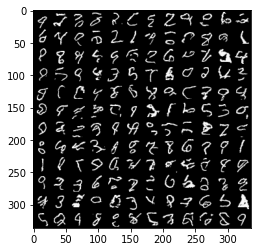

In [25]:
img = cv2.imread('sample.png')[:,:,::-1]
plt.imshow(img)